In [1]:
from ddsp.prior import Prior, PriorDataset
from ddsp.utils import find_checkpoint
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def eq(ten1, ten2, precision=1e-6):
    """Checks equivalence of two tensors"""
    return torch.all(torch.abs(ten1 - ten2) < precision)

### DDSP Model

In [3]:
ddsp_path = '../models/sines/sines-suzuki.ts'
ddsp = torch.jit.load(ddsp_path).to('cpu').pretrained
resampling_factor = ddsp.resampling_factor

### Streaming prior

In [4]:
model_dir = '../training/prior/prior-frogs2-weights-init/'
# checkpoint = '../training/prior/prior-frogs2/best-v3.ckpt'
checkpoint = find_checkpoint(model_dir)
print(f"loading from checkpoint {checkpoint}")
prior = Prior.load_from_checkpoint(checkpoint, streaming=True, strict=False).to('cpu')
print(f"Loaded prior from {checkpoint}. Prior in streaming mode: {prior._streaming}")

window_size = prior.sequence_length
latent_size = prior.latent_size

loading from checkpoint ../training/prior/prior-frogs2-weights-init/best.ckpt
Loaded prior from ../training/prior/prior-frogs2-weights-init/best.ckpt. Prior in streaming mode: True


/opt/homebrew/Caskroom/miniconda/base/envs/ddsp/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:184: Found keys that are in the model state dict but not in the checkpoint: ['_gru.weight_ih_l0', '_gru.weight_hh_l0', '_gru.bias_ih_l0', '_gru.bias_hh_l0', '_gru.weight_ih_l1', '_gru.weight_hh_l1', '_gru.bias_ih_l1', '_gru.bias_hh_l1', '_gru.weight_ih_l2', '_gru.weight_hh_l2', '_gru.bias_ih_l2', '_gru.bias_hh_l2', '_gru.weight_ih_l3', '_gru.weight_hh_l3', '_gru.bias_ih_l3', '_gru.bias_hh_l3', '_gru.weight_ih_l4', '_gru.weight_hh_l4', '_gru.bias_ih_l4', '_gru.bias_hh_l4', '_gru.weight_ih_l5', '_gru.weight_hh_l5', '_gru.bias_ih_l5', '_gru.bias_hh_l5']


#### Check the responsivity

In [65]:
# Quick check
# prior.reset_state()
x = torch.zeros(1,1,prior.latent_size)
prior._embedding
print(x)
prior.sample(prior(x))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.]]])


tensor([[-0.4551, -4.0296,  2.6088,  0.8215,  2.6088, -0.7104,  0.8215, -2.2424]])

### Load training dataset

In [5]:
# Warmup by calculating input from a training dataset chunk
# window_size = 256
prior_dataset = PriorDataset(
    audio_dataset_path='/mnt/mariadata/datasets/ddsp-vae/birds/processed',
    encoding_model_path=ddsp_path,
    sequence_length=window_size*2,
    sampling_rate=44100,
)

Encoding audio dataset...


In [47]:
[prior_dataset._encodings.quantile(0.01), prior_dataset._encodings.quantile(0.99)]

[tensor(-1.6045), tensor(1.4370)]

#### Continuous

In [23]:
# Teacher forcing
sequence = prior_dataset[random.randint(0, len(prior_dataset))]
x = sequence[:window_size].unsqueeze(0)

print(x.shape)
y_hat = prior(x)
y = sequence[window_size]

np.set_printoptions(precision=2)
with torch.no_grad():
    print("accuracy", ((y_hat - y)**2).mean().item())
    print(f"y:\t{y.numpy()}\ny_hat:\t{y_hat.numpy()}")

torch.Size([1, 100, 8])
accuracy 0.13003017008304596
y:	[ 0.72 -0.45 -0.53  0.21  0.54  0.55  0.35  0.47]
y_hat:	[[-0.01 -0.02 -0.03 -0.    0.41  0.45  0.36  0.42]]


#### Discrete

In [7]:
# Predicting next step with discrete prior
x, y = prior_dataset[random.randint(0, len(prior_dataset))]
logits = prior(x.view(1, window_size, latent_size))
y_hat = prior.sample(logits).squeeze(0)

np.set_printoptions(precision=2)
with torch.no_grad():
    print("accuracy", ((y_hat - y)**2).mean().item())
    print(f"y:\t{y.numpy()}\ny_hat:\t{y_hat.numpy()}")

ValueError: too many values to unpack (expected 2)

### Display random dataset latent sequence

#### Continuous

sequence torch.Size([512, 8])
y_hat torch.Size([0, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.Size([1, 8])
current_y torch.S

NameError: name 'y_autoregressive' is not defined

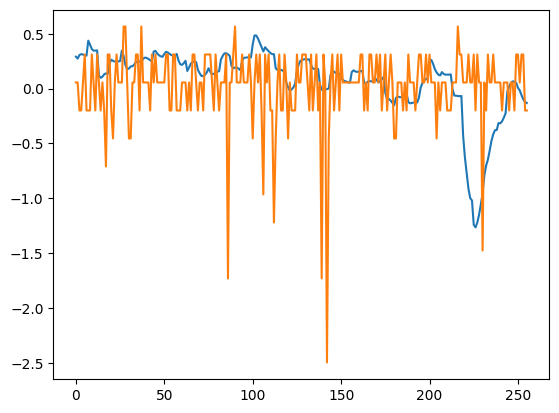

In [81]:
idx = random.randint(0, len(prior_dataset))
sequence = prior_dataset[idx]
    
# predicting on actual inputs
prior.reset_state()
warmup = sequence[:window_size-1, :].unsqueeze(0)
prior(warmup)

y_hat = torch.empty(0, latent_size)
current_x = sequence[window_size-1, :].unsqueeze(0)
for i in range(window_size+1):
    # print("current_x", current_x.shape, current_x)
    current_y = prior(current_x.unsqueeze(0))
    y_hat = torch.cat([y_hat, current_y], dim=0)
    current_x = sequence[window_size+i].unsqueeze(0)

# print("y_hat", y_hat.shape)
y_forced = y_hat.detach().numpy()


# predicting autoregressively
prior.reset_state()
warmup = sequence[:window_size-1, :].unsqueeze(0)
# print("warmup", warmup.shape)
prior(warmup) # warmup

current_x = sequence[window_size-1, :].unsqueeze(0)
# print("current_x", current_x.shape, current_x)
y_hat = torch.empty(0, latent_size)
for i in range(window_size+1):
    current_y = prior(current_x.unsqueeze(0))
    # print("current_y", current_y.shape, current_y)
    y_hat = torch.cat([y_hat, current_y], dim=0)
    # print("y_hat", y_hat.shape, y_hat.shape)
    current_x = current_y
    # print("current_x", current_x.shape, current_x)

y_autoregressive = y_hat.detach().numpy()

y = sequence[window_size:, :]

    
# Comparing sequences: original, prediced on training data, and autoreggresively generated
plt.plot(y[:, 0].detach().numpy(), label='original')
plt.plot(y_forced[:, 0], label='forced')
plt.plot(y_autoregressive[:, 0], label='autoregressive')
plt.legend()
plt.show()

#### Discrete

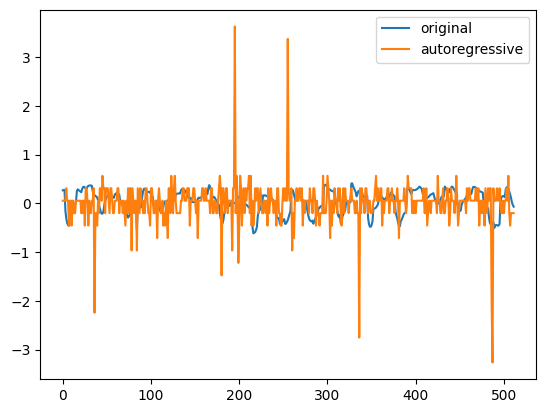

In [6]:
idx = random.randint(0, len(prior_dataset))
x1, _ = prior_dataset[idx]
x2, _ = prior_dataset[idx+1]

x_full = torch.cat([x1, x2], dim=0)

# predicting on actual inputs
# x2_hat = torch.empty(0, x2.shape[1]) # the output of prediction with actual training sequences
# seq_length = x2.shape[0]
# for i in range(seq_length):
#     prior_actual_in = x_full[i:i+seq_length].unsqueeze(0)
#     prior_actual_out = prior.sample(prior(prior_actual_in))
#     x2_hat = torch.cat([x2_hat, prior_actual_out[-1,:].unsqueeze(0)], dim=0)
    

# predicting autoregressively
x2_autoregressive = torch.empty(0, x2.shape[1]) # the output of prediction with training sequences predicted autoregressively from the first one
last_window = x1.unsqueeze(0)
for i in range(x1.shape[0]):
    prior_out = prior.sample(prior(last_window).unsqueeze(0))
    prior_y = prior_out[-1, :].unsqueeze(0)
    x2_autoregressive = torch.cat([x2_autoregressive, prior_y])
    last_window = torch.cat([last_window.squeeze(0)[1:].squeeze(0), prior_y]).unsqueeze(0)
    
    
# Comparing sequences: original, prediced on training data, and autoreggresively generated
plt.plot(x2[:, 0].detach().numpy(), label='original')
# plt.plot(x2_hat[:, 0].detach().numpy(), label='predicted')
plt.plot(x2_autoregressive[:, 0].detach().numpy(), label='autoregressive')
plt.legend()
plt.show()

In [88]:
x2_autoregressive[1, 0], x2_hat[1, 0], x2[1 ,0]

(tensor(0.0555), tensor(-0.1998), tensor(0.1620))

In [90]:
x2.shape

torch.Size([512, 8])

### Generation

In [47]:
# input_latents = torch.rand(1, window_size, latent_size)
input_latents, _ = prior_dataset[random.randint(0, len(prior_dataset))]
input_latents = input_latents.unsqueeze(0)
print(input_latents.shape)

with torch.no_grad():
    output_latents = prior(input_latents)

output = output_latents[:,-1,:]

latents_sequence = []

last_output = torch.zeros_like(output_latents)

# Concatenate last input with new output shifted to the right to fit the window size
last_window = torch.cat([input_latents[:, 1:, :], output.unsqueeze(0)], dim=1)

n_signal = 44100 # 1 sec
print(f"Generating {n_signal//resampling_factor} latents.")
# while True:
for _ in range(n_signal // resampling_factor):
    with torch.no_grad():
        current_output = prior(last_window)[:,-1,:]
#     if eq(current_output, last_output, precision=1e-4):
#         print(f"Converged at {len(latents_sequence)}, diverging")
#         current_output = torch.rand_like(current_output)
        
    if len(latents_sequence) % 1000 == 0:
        print(len(latents_sequence))
    
#     current_output += torch.rand_like(current_output) / 1e-9 # inject randomness
    
    latents_sequence.append(current_output)
    last_window = torch.cat([last_window[:, 1:, :], current_output.unsqueeze(0)], dim=1)
    last_output = current_output

torch.Size([1, 256, 8])
Generating 1378 latents.
0
1000


### Decoding to audio

In [48]:
latents_sequence = torch.cat(latents_sequence, dim=0)

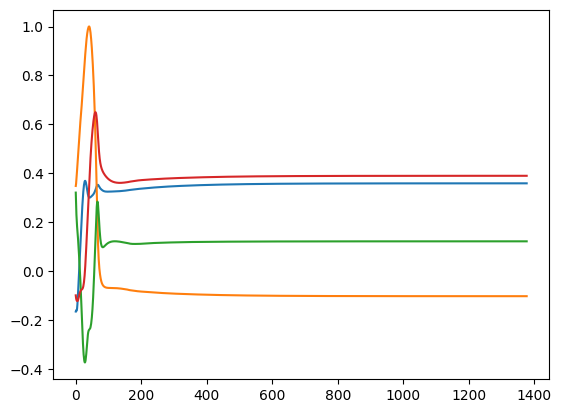

In [53]:
mu, scale = latents_sequence.chunk(2, dim=1)
plt.plot(mu.detach().numpy(), label='mu')
plt.show()

### Streaming Prior

In [212]:
# Loads from checkpoint
prior_stream = Prior.load_from_checkpoint(find_checkpoint(model_dir), streaming=True).eval()

latent_size = prior_stream.latent_size
sequence_length = prior_stream.sequence_length
input_latents = torch.randn(1,sequence_length,latent_size)

# Pass all the initial latents sequence through the prior, one by one
with torch.no_grad():
    for latents in input_latents.squeeze(0):
        output_latents = prior_stream(latents.unsqueeze(0).unsqueeze(0))
    
output_latents = output_latents

# Generate unconditionally until the generated latents are the same
current_output = output_latents
latents_sequence = [current_output]

last_output = torch.zeros_like(output_latents)

equal_times = 0
while True:
    with torch.no_grad():
        current_output = prior_stream(last_output)
    if eq(current_output, last_output):
        equal_times += 1
        
        if equal_times > 1:
            print(f"{current_output}\nsame as\n{last_output}\nrepeated {equal_times}")
            break
    latents_sequence.append(last_output)
    last_output = current_output
    
print(f"Stabilised within {len(latents_sequence)} iterations")

tensor([[[ 0.1960, -0.2971,  0.2392, -0.2192,  0.0251, -0.3232, -0.0211,
           0.0086,  0.4855,  0.6018,  0.5475,  0.5753,  0.5248,  0.4862,
           0.5090,  0.5278]]])
same as
tensor([[[ 0.1960, -0.2971,  0.2392, -0.2192,  0.0251, -0.3232, -0.0211,
           0.0086,  0.4855,  0.6018,  0.5475,  0.5753,  0.5248,  0.4862,
           0.5090,  0.5278]]])
repeated 2
Stabilised within 1006 iterations


# Quantising

## Simple binning strategy (quantising)

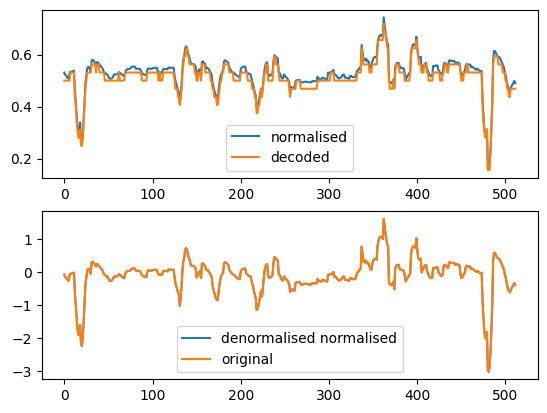

In [83]:
channels = 256

x, y = prior_dataset[random.randint(0, len(prior_dataset))]

x = x[:, 0]

# xmax = torch.max(x)
# xmin = torch.min(x)

xmax = prior_dataset.max_value
xmin = prior_dataset.min_value

normalise = lambda x: (x-xmin) / (xmax-xmin)
denormalise = lambda x: x * (xmax-xmin) + xmin

normalised = normalise(x)
x_denormalised = denormalise(normalised)

encode = lambda x, bins: (x*bins).long()
decode = lambda y, bins: (y/bins)

bins = 32
encoded = encode(normalised, bins)
decoded = decode(encoded, bins)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(normalised, label='normalised')
ax1.plot(decoded, label='decoded')
ax1.legend()

y = denormalise(decoded)
ax2.plot(x_denormalised, label='denormalised normalised')
ax2.plot(x, label='original')
# ax2.plot(y, label='decoded denormalised')
ax2.legend()
plt.show()

## Mu-law quantising

In [85]:
from torchaudio.transforms import MuLawEncoding, MuLawDecoding

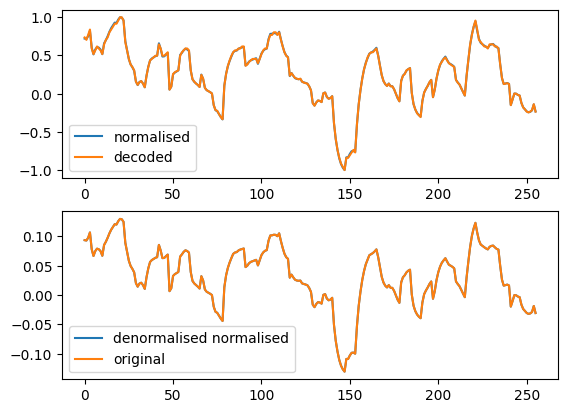

In [161]:
channels = 256
encode, decode = MuLawEncoding(channels), MuLawDecoding(channels)

x, y = prior_dataset[random.randint(0, len(prior_dataset))]
x = x[:, 0]

xmin = torch.min(x)
xmax = torch.max(x)

normalise = lambda x: 2*((x-xmin) / (xmax-xmin)) - 1
denormalise = lambda y: 0.5*(y+1) * (xmax-xmin) + xmin

normalised = normalise(x)
x_denormalised = denormalise(normalised)

encoded = encode(normalised)
decoded = decode(encoded)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(normalised, label='normalised')
ax1.plot(decoded, label='decoded')
ax1.legend()

y = denormalise(decoded)
ax2.plot(x_denormalised, label='denormalised normalised')
ax2.plot(x, label='original')
# ax2.plot(y, label='decoded denormalised')
ax2.legend()
plt.show()

In [147]:
normalised.min()

tensor(-2.1049)

# Transformer Prior

In [3]:
from ddsp.prior import Prior, PriorDataset

### one-step-ahead

In [15]:
# Warmup by calculating input from a training dataset chunk
window_size = 64
prior_dataset = PriorDataset(
    audio_dataset_path='/mnt/mariadata/datasets/ddsp-vae/birds/processed',
    encoding_model_path=ddsp_path,
    sequence_length=window_size,
    sampling_rate=44100,
)

TypeError: PriorDataset.__init__() missing 1 required positional argument: 'db_file'

In [16]:
prior = Prior.load_from_checkpoint('../training/transformer-prior/birds-prior/best-v3.ckpt').eval()

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: Error(s) in loading state_dict for Prior:
	Missing key(s) in state_dict: "_projection.0.weight", "_projection.0.bias", "_projection.1.weight", "_projection.1.bias", "_positional_encoding._positional_encoding", "_out.0.weight", "_out.0.bias", "_out.1.weight", "_out.1.bias". 
	Unexpected key(s) in state_dict: "_projection.weight", "_projection.bias", "_positional_encoding.pe", "_out.weight", "_out.bias". 

In [13]:
seq = prior_dataset[1].to(prior.device)
x, y = seq[:window_size, ...], seq[window_size, ...]
y_hat = prior(x.unsqueeze(0))

In [18]:
(y_hat-y).mean()

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

In [27]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

predicted = []
predicted_autoregressive = []
actual = []

st = random.randint(0, 20000)

x_ar = None

for i in range(256):
    seq = prior_dataset[st+i].to(prior.device)
    x, y = seq[:window_size, ...], seq[window_size, ...]
    
    if x_ar is None:
        x_ar = x.clone()
        
    with torch.no_grad():
        y_hat = prior(x.unsqueeze(0))
        y_hat_ar = prior(x_ar.unsqueeze(0))
        
    predicted += [y_hat.squeeze().cpu().numpy()]
    
    predicted_autoregressive += [y_hat_ar.squeeze().cpu().numpy()]
    x_ar = torch.cat([x_ar[1:, :], y_hat_ar], dim=0)
    
    actual += [y.squeeze().cpu().numpy()]
    

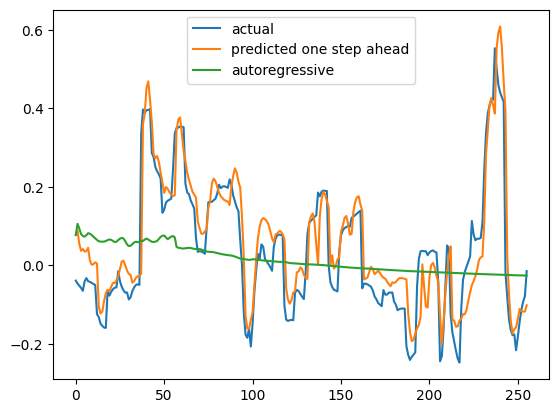

In [30]:
plt.plot([act[1] for act in actual[:256]], label='actual')
plt.plot([pred[1] for pred in predicted[:256]], label='predicted one step ahead')
plt.plot([pred_ar[1] for pred_ar in predicted_autoregressive[:256]], label='autoregressive')
plt.legend()
plt.show()

In [81]:
seq.clone()

tensor([[ 0.0536, -0.1391,  0.0205,  ...,  0.5051,  0.5216,  0.5329],
        [ 0.0448, -0.1402,  0.0180,  ...,  0.5052,  0.5219,  0.5329],
        [-0.1393, -0.0703, -0.0970,  ...,  0.4954,  0.5216,  0.5351],
        ...,
        [ 0.1077,  0.1937, -0.1415,  ...,  0.5328,  0.5401,  0.5413],
        [ 0.0959,  0.2055, -0.1288,  ...,  0.5265,  0.5407,  0.5416],
        [ 0.0889,  0.2145, -0.1225,  ...,  0.5230,  0.5408,  0.5415]])

### seq2seq

In [4]:
ddsp_path = '../models/sines/sines-suzuki.ts'
ddsp = torch.jit.load(ddsp_path).pretrained
resampling_factor = ddsp.resampling_factor

In [20]:
# Warmup by calculating input from a training dataset chunk
seq_len = 256
prior_dataset = PriorDataset(
    audio_dataset_path='/mnt/mariadata/datasets/ddsp-vae/suzuki/processed',
    encoding_model_path=ddsp_path,
    sequence_length=seq_len,
    sampling_rate=44100,
)

Encoding audio dataset...


In [7]:
prior = Prior.load_from_checkpoint('../training/transformer-prior/suzuki-prior-multistep/best.ckpt')

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


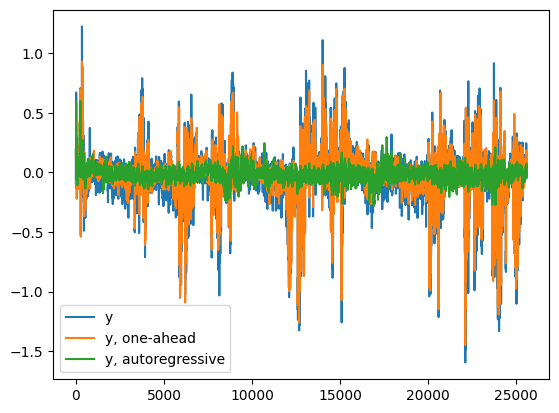

In [36]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

predicted = []
predicted_autoregressive = []
actual = []

st = random.randint(0, 20000)

y_oa_seq = [] # y, one-ahead
y_ar_seq = []
y_seq = []

for i in range(100):
    seq = prior_dataset[st+i*seq_len].to(prior.device)
    
    # seq = torch.randn(seq_len*2, 16).to(prior.device)+1 # random
    
    x, y = seq[:seq_len, ...], seq[seq_len:, ...]
    
    
    with torch.no_grad():
        y_oa = prior(x.unsqueeze(0)).squeeze(0)

        y_ar_input = x
        if len(y_ar_seq) > 0:
            y_ar_input = y_ar_seq[-1]
        y_ar = prior(y_ar_input.unsqueeze(0)).squeeze(0)

    y_oa_seq.append(y_oa)
    y_ar_seq.append(y_ar)
    y_seq.append(y)

y_oa_seq = torch.cat(y_oa_seq, dim=0)
y_ar_seq = torch.cat(y_ar_seq, dim=0)
y_seq = torch.cat(y_seq, dim=0)

plt.plot(y_seq[:, 0].cpu().numpy(), label='y')
plt.plot(y_oa_seq[:, 0].cpu().numpy(), label='y, one-ahead')
plt.plot(y_ar_seq[:, 0].cpu().numpy(), label='y, autoregressive')
plt.legend()
plt.show()

### shifted sequence

In [4]:
ddsp_path = '../models/sines/sines-suzuki.ts'
ddsp = torch.jit.load(ddsp_path, map_location='cuda').to('cuda').pretrained.to('cuda')
resampling_factor = ddsp.resampling_factor

In [26]:
# Warmup by calculating input from a training dataset chunk
context_length = 2000
prior_dataset = PriorDataset(
    audio_dataset_path='/mnt/mariadata/datasets/ddsp-vae/suzuki/processed',
    encoding_model_path=ddsp_path,
    sequence_length=context_length+1,
    sampling_rate=44100,
)

Encoding audio dataset...


In [8]:
len(prior_dataset)

1779

In [33]:
prior = Prior.load_from_checkpoint('../training/transformer-prior-shifted/suzuki-2000-non-overlapping/best.ckpt')

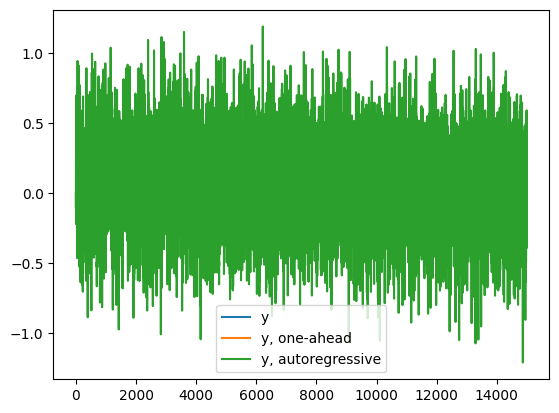

In [34]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

latent_size = prior_dataset[0].size(1)

generated_seq_len = 15000
st = random.randint(0, len(prior_dataset))

y_oa_seq = torch.empty([0, latent_size], device='cuda') # y, one-ahead
y_ar_seq = torch.empty([0, latent_size], device='cuda')
y_seq = torch.empty([0, latent_size], device='cuda')

x_ar = None

# FIX THIS
seq = prior_dataset[st].to(prior.device)
for i in range(generated_seq_len):
    # seq = prior_dataset[st+i].to(prior.device)
    
    x = seq[1:, ...] # [seq_len, latent_size]
    y = seq[-1, ...] # [latent_size]

    if x_ar is None:
        x_ar = x.clone()
    
    with torch.no_grad():
        # y_oa = prior(x.unsqueeze(0)).squeeze(0)[-1] # [latent_size]
        y_ar = prior(x_ar.unsqueeze(0)).squeeze(0)[-1] # [latent_size]

        # Append predicted code to autoregressive input
        x_ar = torch.cat([x_ar[1:, ...], y_ar.unsqueeze(0)], dim=0)

    # y_oa_seq = torch.cat([y_oa_seq, y_oa.unsqueeze(0)], dim=0)
    y_ar_seq = torch.cat([y_ar_seq, y_ar.unsqueeze(0)], dim=0)
    # y_seq = torch.cat([y_seq, y.unsqueeze(0)], dim=0)

plt.plot(y_seq[:, 0].cpu().numpy(), label='y')
plt.plot(y_oa_seq[:, 0].cpu().numpy(), label='y, one-ahead')
plt.plot(y_ar_seq[:, 0].cpu().numpy(), label='y, autoregressive')
plt.legend()
plt.show()

#### visualising dimensions

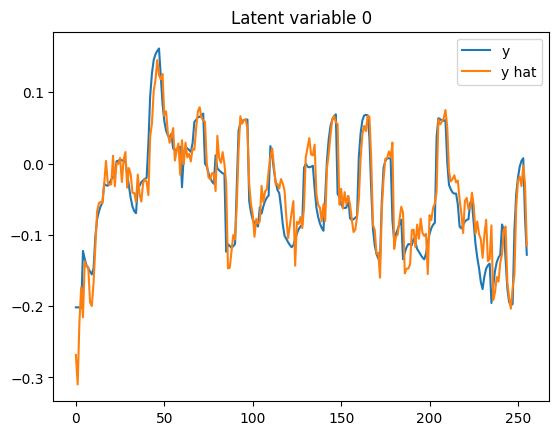

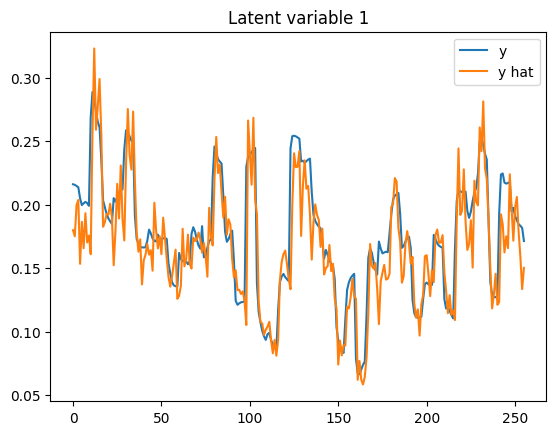

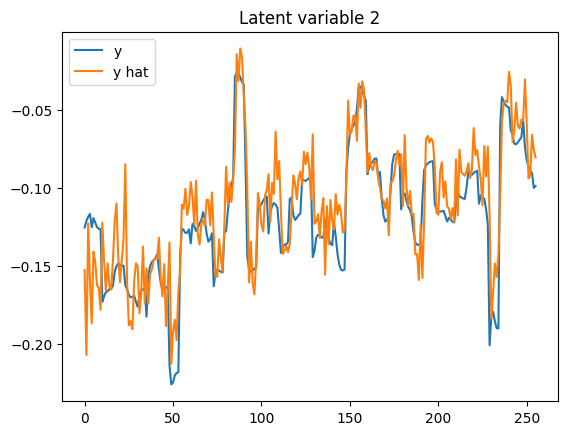

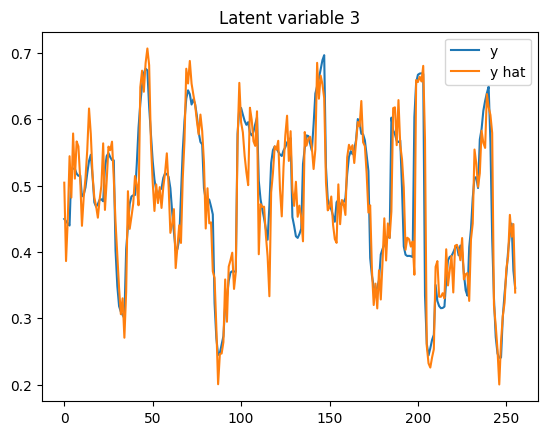

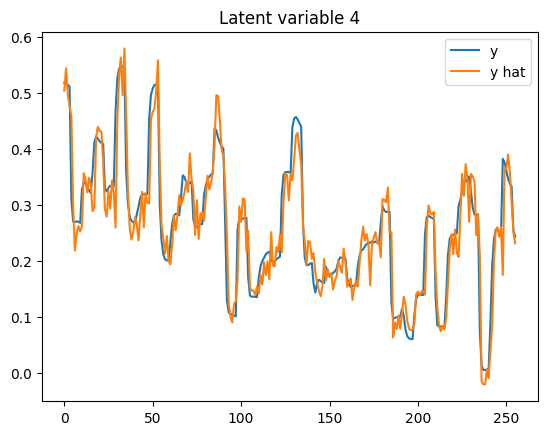

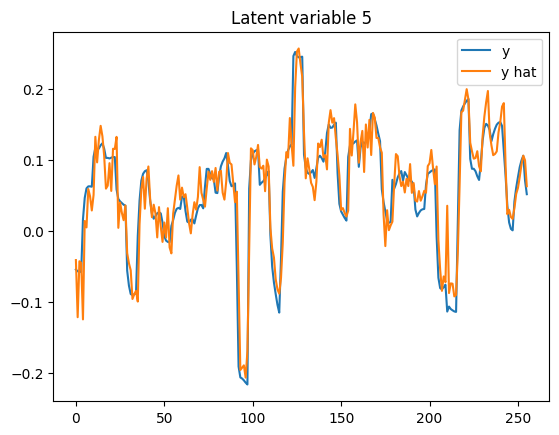

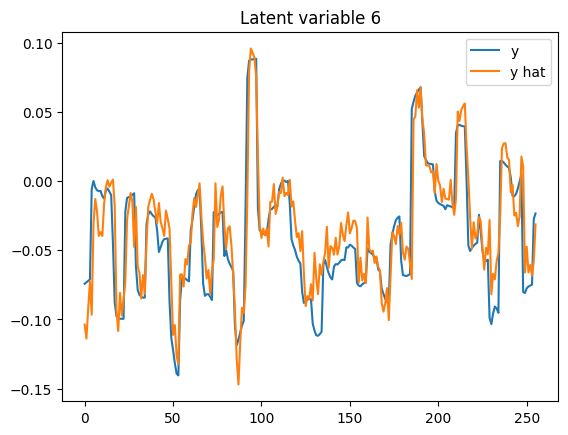

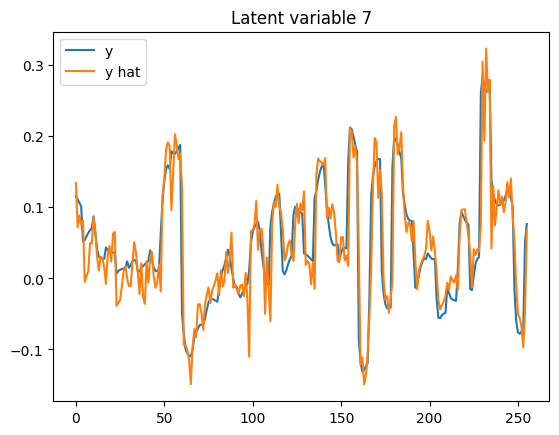

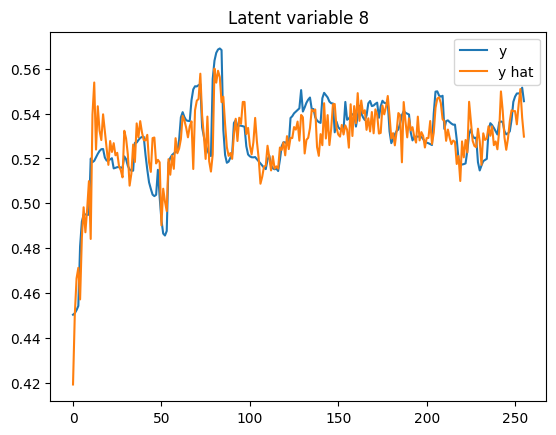

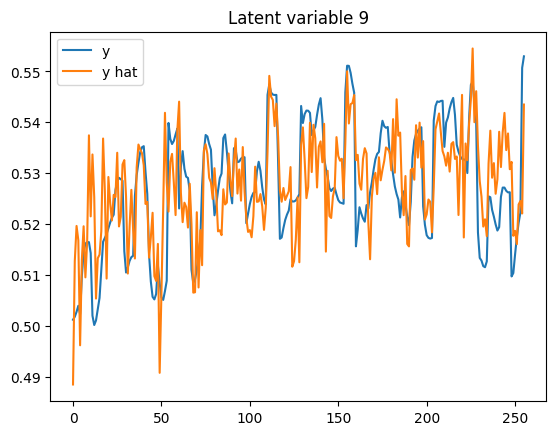

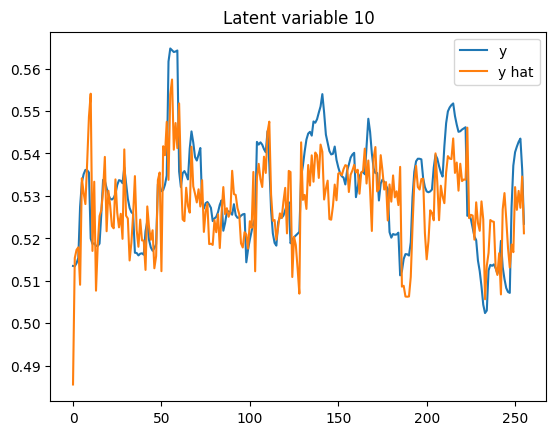

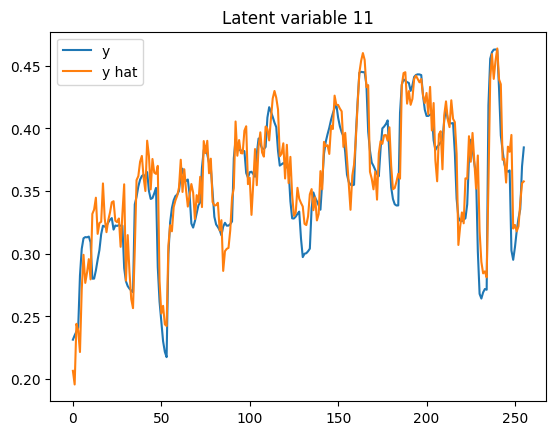

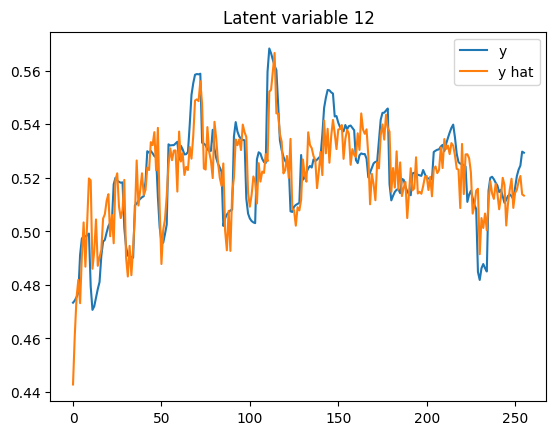

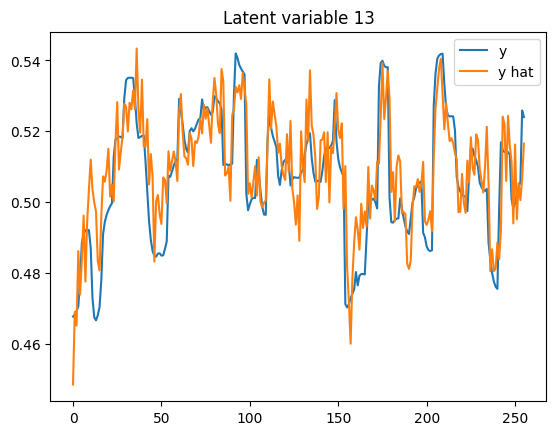

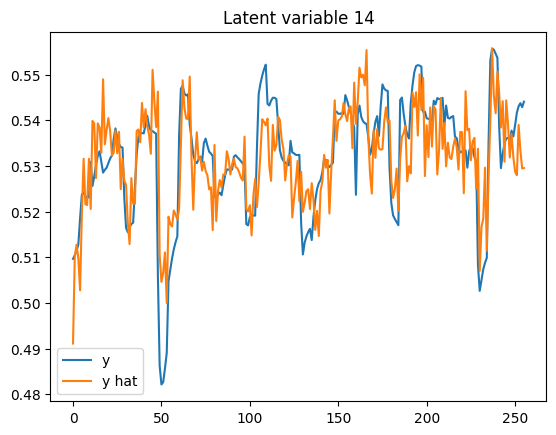

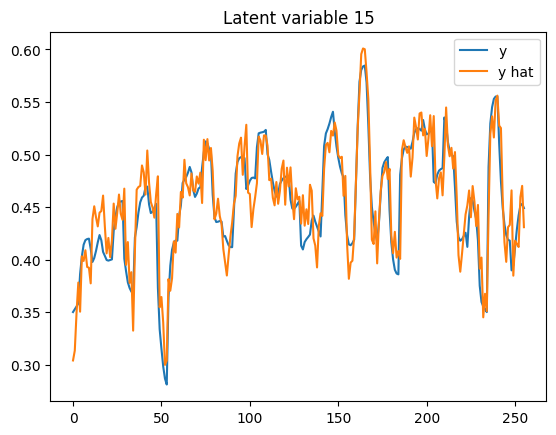

In [66]:
seq = prior_dataset[70]
x, y = seq[:-1], seq[1:]
with torch.no_grad():
    y_hat = prior(x.unsqueeze(0).cuda())

(y_hat-y.cuda())
for dim in range(y_hat.shape[-1]):
    plt.title(f"Latent variable {dim}")
    plt.plot(y.squeeze(0)[:, dim].cpu().numpy(), label='y')
    plt.plot(y_hat.squeeze(0)[:, dim].cpu().numpy(), label='y hat')
    plt.legend()
    plt.show()

### generating audio

In [35]:
import IPython.display as ipd

latent_input = y_seq
latent_input = y_oa_seq
latent_input = y_ar_seq

with torch.no_grad():
    # reparametrize
    latents = ddsp.encoder.reparametrize(*(latent_input.cuda().chunk(2, dim=1))).cuda()

    # generate synth params
    synth_params = ddsp.decoder(latents.unsqueeze(0).detach())
    synth_params = [sp.cpu() for sp in synth_params]

    # generate audio
    audio = ddsp._synthesize(*synth_params)

ipd.Audio(audio.detach().cpu().squeeze(), rate=44100)

## Causal mask

tensor([[ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True, False,  True,  ..., False, False, False],
        ...,
        [ True, False,  True,  ..., False, False, False],
        [ True, False,  True,  ..., False, False, False],
        [ True, False,  True,  ..., False, False,  True]])


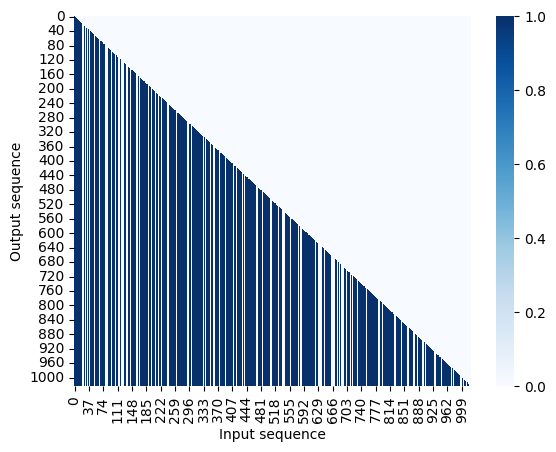

In [129]:
import torch
causal_mask = ~torch.triu(torch.ones(1024, 1024), diagonal=1).bool()

teacher_forcing_ratio = 0.75

indices = torch.rand(causal_mask.size(0))
indices = indices > teacher_forcing_ratio
causal_mask[:, indices] = False

print(causal_mask)

import seaborn as sns
sns.heatmap(causal_mask, cmap='Blues')
plt.xlabel('Input sequence')
plt.ylabel('Output sequence')
plt.show()

In [132]:
~torch.nn.Transformer.generate_square_subsequent_mask(512).bool()

tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [133]:
torch.nn.Transformer.generate_square_subsequent_mask(512)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])